
**Imbalanced data refers to a scenario in classification problems where the number of observations in each class significantly differs. In such datasets, one class (the majority class) outnumbers the other class (the minority class). This imbalance can bias the model in favour of the majority class, resulting in poor predictive performance on the minority class, which is often the class. This project aim to address the issue of minority class in a dataset with machine learning**


In [2]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance-claim/Insurance claims data.csv


In [3]:
#Load the dataset
insurance_data = pd.read_csv('/kaggle/input/insurance-claim/Insurance claims data.csv')

In [4]:
#Inspect the dataset
insurance_data.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

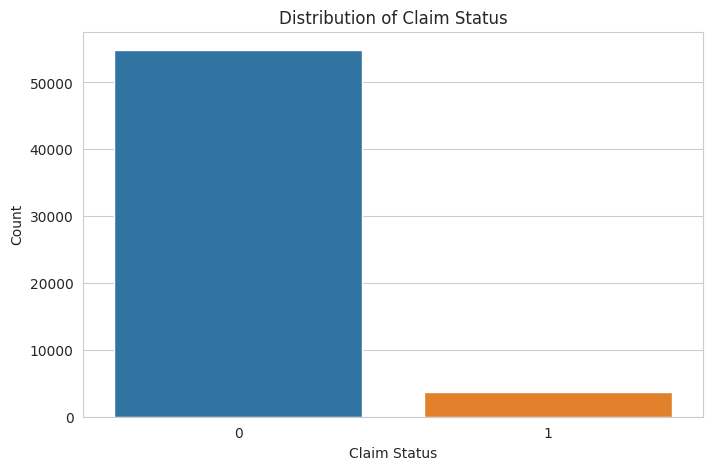

In [6]:
#Visualizing the claim stateus with a countplot
plt.figure(figsize=(8,5))
sns.countplot(x= 'claim_status',data= insurance_data)
plt.title("Distribution of Claim Status")
plt.xlabel("Claim Status")
plt.ylabel("Count")
plt.show()

It is evident that more people has not claimed their insurance and only few people have done. claim_state convention, 1= claimed, 0= not claimed

In [8]:
#Selecting some relevant numeric features; length, Vehicle Age, Customer Age
sl_va_ca = ['subscription_length','vehicle_age','customer_age']

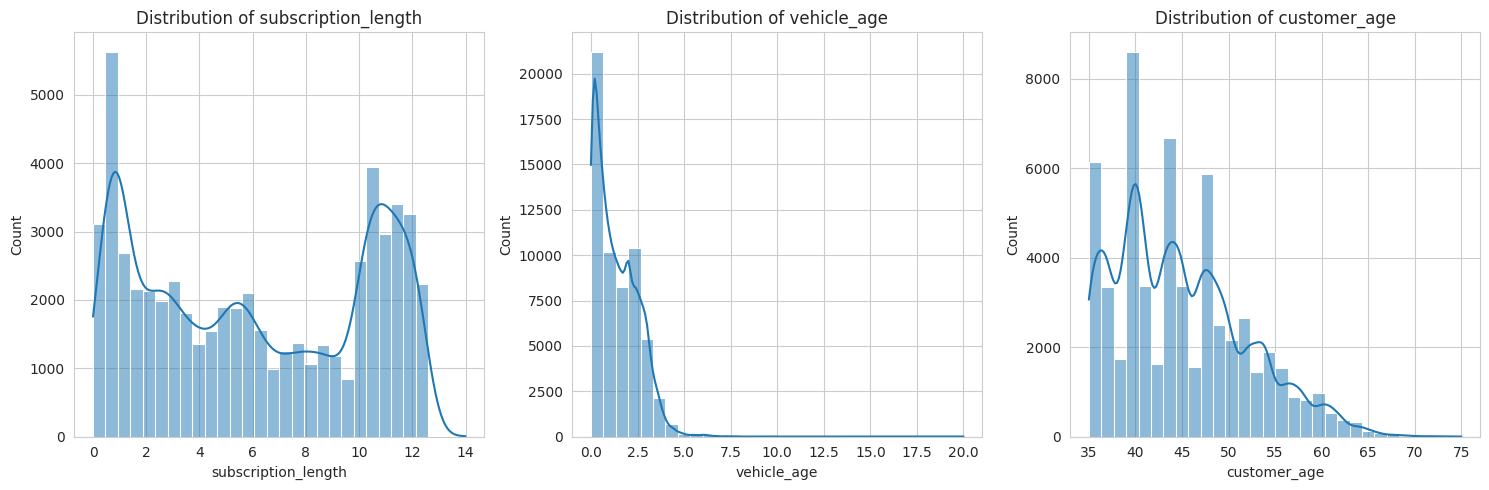

In [9]:
#Visualizing the selected numerical features
plt.figure(figsize=(15,5))
for i, columns in enumerate(sl_va_ca,1):
    plt.subplot(1,3,i)
    sns.histplot(insurance_data[columns], bins= 30,kde= True)
    plt.title(f'Distribution of {columns}')
    
plt.tight_layout()
plt.show()
    
 

In [10]:
# selecting some relevant categorical columns for analysis
categorical_columns = ['region_code', 'segment', 'fuel_type']

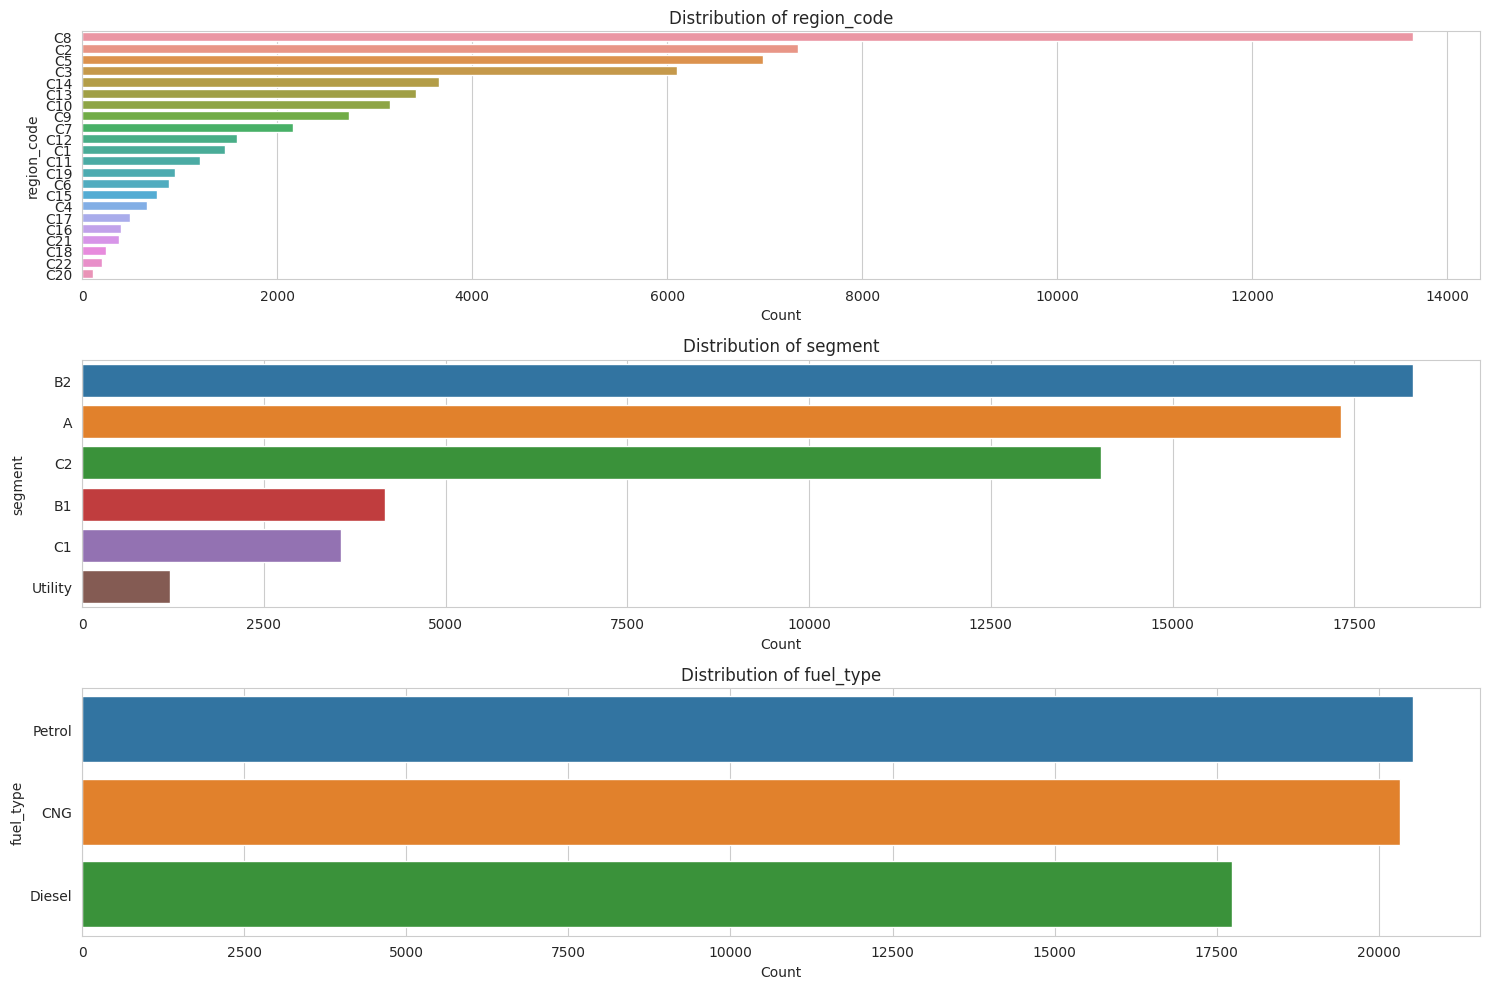

In [11]:
plt.figure(figsize= (15,10))
for i, columns in enumerate(categorical_columns,1):
    plt.subplot(3,1,i)
    sns.countplot(y= columns, data= insurance_data,order= insurance_data[columns].value_counts().index)
    plt.title(f'Distribution of {columns}')
    plt.xlabel('Count')
    plt.ylabel(columns)

plt.tight_layout()
plt.show()

For ‘region_code,’ there is a wide variety of codes, each with varying counts, but a few specific codes dominate with much higher counts than others. In the ‘segment’ distribution, there are fewer categories, with the ‘B2’ segment being the most common, followed by ‘A’ and ‘C2,’ and the ‘Utility’ segment being the least common. Lastly, ‘fuel_type’ shows three categories: ‘Petrol’ has the highest count than CNG and Diesel.

# Handling Class imbalance

In [12]:
majority = insurance_data[insurance_data['claim_status'] == 0]
minority = insurance_data[insurance_data['claim_status'] == 1]

In [13]:
minority_oversampled = resample(minority,replace=True, n_samples = len(majority), random_state= 42)

oversampled_data = pd.concat([majority, minority_oversampled])
oversampled_distribution = oversampled_data['claim_status'].value_counts()
oversampled_distribution

claim_status
0    54844
1    54844
Name: count, dtype: int64

After performing oversampling on the minority class, both classes are balanced with 54,844 entries each. Now, let’s have a look at some key variables to see what the balanced data looks like:

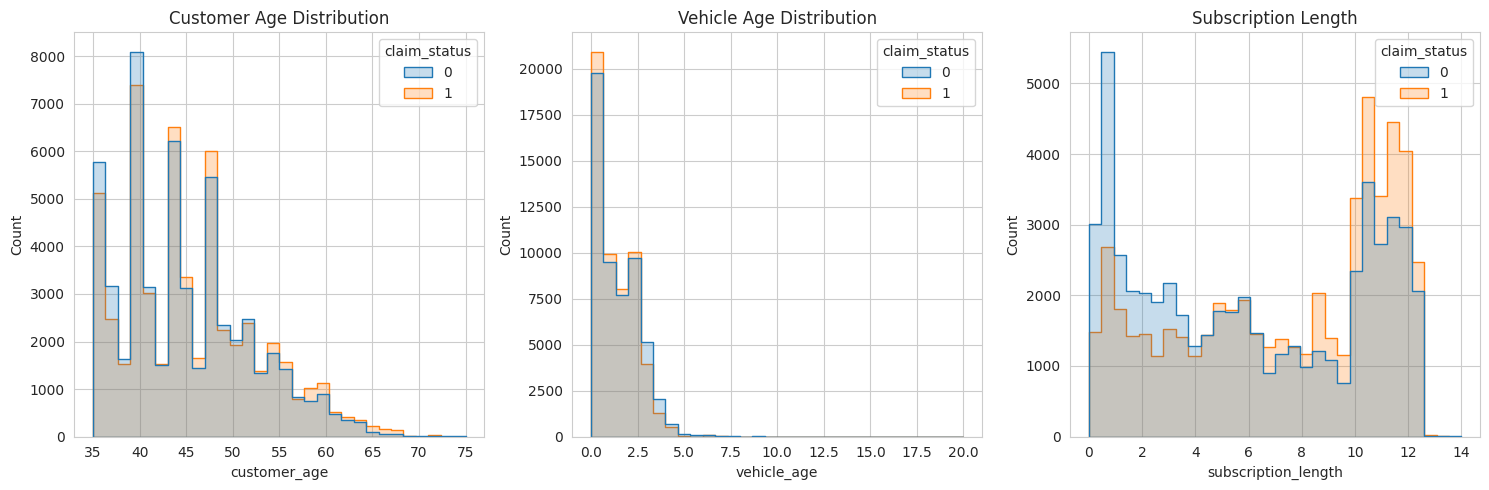

In [14]:
# plotting the distribution of 'customer_age', 'vehicle_age', and 'subscription_length' with respect to 'claim_status'
plt.figure(figsize=(15, 5))

#customer_age distribution
plt.subplot(1,3,1)
sns.histplot(oversampled_data, x= 'customer_age', hue='claim_status',element= 'step',bins=30)
plt.title('Customer Age Distribution')

plt.subplot(1,3,2)
sns.histplot(oversampled_data, x= 'vehicle_age', hue='claim_status',element= 'step',bins=30)
plt.title('Vehicle Age Distribution')

plt.subplot(1,3,3)
sns.histplot(oversampled_data, x= 'subscription_length', hue='claim_status',element= 'step',bins=30)
plt.title('Subscription Length')

plt.tight_layout()
plt.show()

The oversampled data does look like the original data. So, let’s move forward.

Feature Selection
Now, we will identify the most important variables for predicting insurance frequency claims. It involves analyzing both categorical and numerical features to determine their impact on the target variable. We will use feature importance techniques suitable for both types of variables. Let’s start with feature selection to identify the most important variables:

In [15]:
#Encode categorical data
le = LabelEncoder()

encoded_data = insurance_data.apply(lambda col: le.fit_transform(col) if col.dtype =='object' else col)

#split data into target and predictor
x= encoded_data.drop('claim_status', axis=1)
y = encoded_data['claim_status']

In [16]:
#create a random forest model

rf_model = RandomForestClassifier()
rf_model.fit(x,y)

RandomForestClassifier()

In [17]:
feature_importance = rf_model.feature_importances_

In [18]:
features_df = pd.DataFrame({'Feature': x.columns,'Importance':feature_importance})
features_df = features_df.sort_values(by= 'Importance', ascending = False)
features_df.head(10)

,Feature,Importance
0,policy_id,0.319931
1,subscription_length,0.244962
3,customer_age,0.176677
2,vehicle_age,0.136921
5,region_density,0.055125
4,region_code,0.053969
7,model,0.001024
24,length,0.000855
25,width,0.000788
23,turning_radius,0.000760


The top 10 most important variables for predicting insurance frequency claims, according to the Random Forest model, are:

policy_id: Unique identifier for the insurance policy
subscription_length: Length of the insurance subscription
customer_age: Age of the customer
vehicle_age: Age of the vehicle
region_density: Population density of the region
region_code: Code representing the region
model: Model of the vehicle
length: Length of the vehicle
engine_type: Type of engine in the vehicle
gross_weight: Gross weight of the vehicle

These variables appear to have the most influence on the likelihood of an insurance claim being made. However, 
it’s notable that policy_id has a very high importance, but it is just an identifier and has no relationship with insurance claims, hence it will be dropped

# Model Training
The next step is to build a predictive model using the oversampled data. Given the nature of the task (binary classification), 
a suitable algorithm could be logistic regression, random forest, or gradient boosting. Considering the effectiveness of random forests 
in handling both numerical and categorical data and their ability to model complex interactions, we’ll proceed with a Random Forest classifier:

In [19]:
oversampled_data = oversampled_data.drop('policy_id', axis = 1)

#spliting oversampled data into predictor and target
X_oversampled_data = oversampled_data.drop('claim_status', axis = 1)
y_oversampled_data = oversampled_data['claim_status']

In [20]:
#Encoding categorical data
X_oversampled_data_encoded = X_oversampled_data.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

In [21]:
#splitting the dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(X_oversampled_data_encoded,y_oversampled_data,test_size=0.25,random_state=42 )

In [22]:
#creating and training the random forest classifier

rf_model_oversampled = RandomForestClassifier()
rf_model_oversampled.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
y_pred = rf_model_oversampled.predict(X_test)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13869
           1       0.96      1.00      0.98     13553

    accuracy                           0.98     27422
   macro avg       0.98      0.98      0.98     27422
weighted avg       0.98      0.98      0.98     27422



The classification report above provides various metrics to evaluate the performance of the predictive model on the test data. Here’s an interpretation of the results:

For class 0 (no claim), precision is 1.00, meaning that when the model predicts no claim, it is correct 100% of the time. For class 1 (claim), precision is 0.96, indicating that when the model predicts a claim, it is correct 96% of the time.
For class 0, recall is 0.96, signifying that the model correctly identifies 96% of all actual no-claim instances. For class 1, recall is 1.00, showing that the model correctly identifies 100% of all actual claim instances.

Now, let’s label the original imbalanced data using our model to see how many instances are correctly classified from our model:

In [29]:
original_encoded = insurance_data.drop('policy_id', axis=1)
encoders = {col: LabelEncoder().fit(X_oversampled_data[col]) for col in X_oversampled_data.select_dtypes(include = ['object']).columns}
for col in original_encoded.select_dtypes(include = ['object']).columns:
    if col in encoders:
        original_encoded[col] = encoders[col].transform(original_encoded[col])
original_encoded_predictions = rf_model_oversampled.predict(original_encoded.drop('claim_status', axis = 1))
comparison_df = pd.DataFrame({'Actual':original_encoded['claim_status'], 'Predicted': original_encoded_predictions})

Let's visualize the percentage of correctly classified and misclassified samples:

In [36]:
correctly_classified = (comparison_df['Actual'] == comparison_df['Predicted']).sum()
incorrectly_classified = (comparison_df['Actual'] != comparison_df['Predicted']).sum()

In [37]:
classification_count = [correctly_classified,incorrectly_classified ]
labels = ["Correctly Classified", 'Incorrectly Classified']

In [38]:
classification_count

[57740, 852]

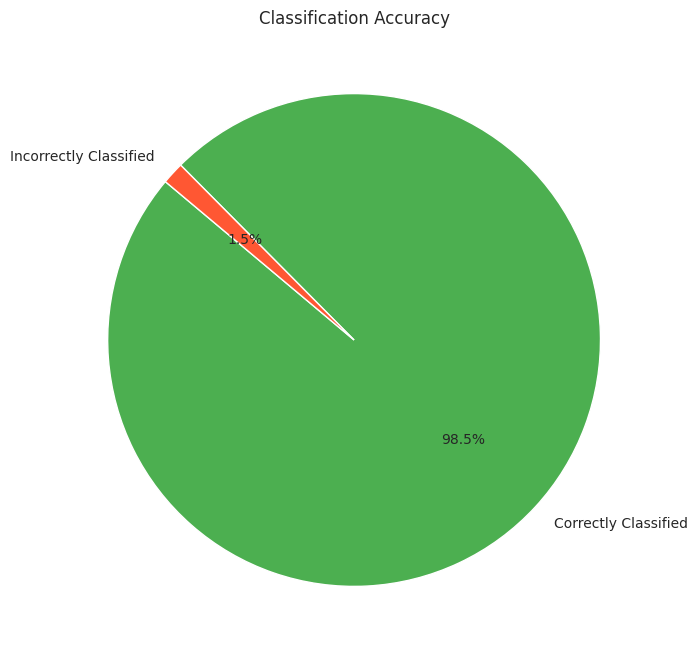

In [39]:
#Create a Pie Chart

plt.figure(figsize = (8,8))
plt.pie(classification_count, labels= labels,autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FF5733'])
plt.title('Classification Accuracy')
plt.show()

So, we can see that our model performs well on the original imbalanced data as well.

# Summary
So, this is how to handle class imbalance and perform classification on imbalanced data. Imbalanced data refers to a situation in classification problems where the number of observations in each class significantly differs. In such datasets, one class (the majority class) vastly outnumbers the other class (the minority class). This imbalance can lead to a biased model that favours the majority class, resulting in poor predictive performance on the minority class, which is often the class of greater interest.